In [1]:
import sys

import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv', index_col=['Id'])
test = pd.read_csv('data/test.csv', index_col=['Id'])

In [3]:
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


In [4]:
del test

In [5]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
print((train.loc[train['YearBuilt'] == train['YearRemodAdd']]).shape)

(764, 80)


Ако къщата не е ремоделирана не ни интересува колоната 'YearRemodAdd'.

In [7]:
train['YearRemodAdd'] = np.where(train['YearBuilt'] != train['YearRemodAdd'], train['YearRemodAdd'], 0)

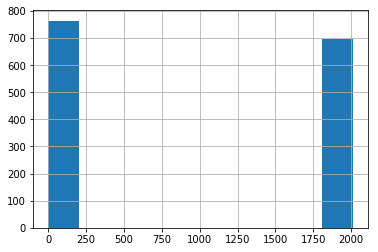

In [8]:
train['YearRemodAdd'].hist();

In [9]:
print((train.loc[train['YearBuilt'] == train['YrSold']]).shape)
print(train.loc[train['SaleType'] == 'New'].shape)

(64, 80)
(122, 80)


Само 64 къщи са били продадени в същата година в която са построени, значи това едва ли ще ни е полезна информация.

In [10]:
train.drop(['MoSold'], axis=1, inplace=True)
train.drop(['YrSold'], axis=1, inplace=True)

"Masonry veneer type" не трябва да ни интересува ако го няма.

In [11]:
#train['MasVnrType'] = np.where(train['MasVnrType'] != 'None', train['MasVnrType'], "")
train['MasVnrType'].fillna('None', inplace=True)

In [12]:
from sklearn.model_selection import train_test_split

train_no_sale_price = train.drop(labels=['SalePrice'], axis=1)
train_sale_price = train['SalePrice']

Да премахнем информацията която нямаме

In [13]:
numeric_column_names = train_no_sale_price.describe().columns;

In [14]:
train_no_sale_price[numeric_column_names] = train_no_sale_price[numeric_column_names].fillna(0);

In [15]:
categorical_columns = train_no_sale_price.dtypes[train_no_sale_price.dtypes == 'object'].index

In [16]:
train_no_sale_price = train_no_sale_price.fillna("")

In [17]:
x_train, x_test, y_train, y_test = train_test_split(train_no_sale_price, 
                                                    train_sale_price, 
                                                    test_size=0.3, 
                                                    random_state=516)

In [18]:
encoders = {col: LabelEncoder().fit(train_no_sale_price[col]) for col in categorical_columns}

In [19]:
def encode_categorical(data, columns, encoders):
    data = data.fillna("")
    return pd.DataFrame({col: encoders[col].transform(data[col]) for col in columns},
                        index = data.index)

In [20]:
train_encoded = encode_categorical(train_no_sale_price, categorical_columns, encoders)

In [21]:
one_hot_encoded = OneHotEncoder(categories='auto').fit(train_encoded)

In [22]:
print(one_hot_encoded.transform(train_encoded).shape)

(1460, 267)


In [23]:
one_hot_x_train = one_hot_encoded.transform(encode_categorical(x_train[categorical_columns], categorical_columns, encoders))
one_hot_x_test = one_hot_encoded.transform(encode_categorical(x_test[categorical_columns], categorical_columns, encoders))

In [24]:
from sklearn.linear_model import LinearRegression 
cat_regression = LinearRegression().fit(one_hot_x_train, y_train)
print(cat_regression.score(one_hot_x_train, y_train))
print(cat_regression.score(one_hot_x_test, y_test))

0.8645558677313068
0.769894829715964


In [25]:
x_train[x_train.describe().columns].shape, one_hot_x_train.shape

((1022, 34), (1022, 267))

In [26]:
new_x_train = pd.np.concatenate([one_hot_x_train.todense(), x_train[x_train.describe().columns]], axis=1)
new_x_test = pd.np.concatenate([one_hot_x_test.todense(), x_test[x_test.describe().columns]], axis=1)
print(new_x_train.shape, new_x_test.shape)

(1022, 301) (438, 301)


In [27]:
all_data_lr = LinearRegression().fit(new_x_train, y_train)
print(all_data_lr.score(new_x_train, y_train))
print(all_data_lr.score(new_x_test, y_test))

0.9311935301017937
0.8889443361429498


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Тък осъзнах колко голямо значение има как сме разделили train и test set-а. С random_state=2266, даваше огромен овърфит.

Нека пробваме Rigde и Lasso

In [28]:
from sklearn.linear_model import Ridge

alpha = [0.01, 0.1, 1, 10, 100]

for a in alpha:
    ridge = Ridge(alpha = a).fit(new_x_train, y_train)
    print('alpha:', a)
    print(ridge.score(new_x_train, y_train), ridge.score(new_x_test, y_test))
    print()

alpha: 0.01
0.9311693512513219 0.8905009649330101

alpha: 0.1
0.9299897860705705 0.8957088026792984

alpha: 1
0.9175791545727323 0.8909821086243035

alpha: 10
0.8957765976667502 0.8776008355618825

alpha: 100
0.8600864011323682 0.8626643903097403



In [29]:
from sklearn.linear_model import Lasso

alpha = [0.1, 1, 10, 75, 100]

for a in alpha:
    lasso = Lasso(alpha = a).fit(new_x_train, y_train)
    print('alpha:', a)
    print(lasso.score(new_x_train, y_train), lasso.score(new_x_test, y_test))
    print()

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha: 0.1
0.931131700692785 0.8968439920517611

alpha: 1
0.9310929987043548 0.8992660378662878

alpha: 10
0.9293696544840134 0.909113039600073

alpha: 75
0.9189347115169366 0.9071988999188714

alpha: 100
0.9152287937764969 0.9047323381917555



=> Lasso с alpha 75 е по-добър за този модел

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


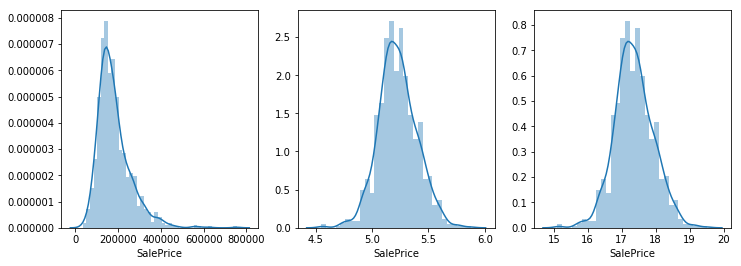

In [30]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.distplot(y_train)
plt.subplot(1, 3, 2)
sns.distplot(pd.np.log10(y_train))
plt.subplot(1, 3, 3)
sns.distplot(pd.np.log2(y_train))

Да пробваме с log2 вместо log10

In [31]:
all_data_lr = LinearRegression().fit(new_x_train, pd.np.log2(y_train))
print(all_data_lr.score(new_x_train, pd.np.log2(y_train)))
print(all_data_lr.score(new_x_test, pd.np.log2(y_test)))

0.9455368438558178
0.8903099203154732


Няма особено голяма разлика

In [32]:
y_train_log10 = pd.np.log10(y_train)
y_test_log10 = pd.np.log10(y_test)

Ще пробвам това как се е отразило на Ridge и Lasso

In [33]:
alphas = [0.01, 0.1, 1, 10, 100]
for alpha in alphas:
    ridge_log = Ridge(alpha = alpha).fit(new_x_train, y_train_log10)
    print('alpha:', alpha)
    print(ridge_log.score(new_x_train, y_train_log10), ridge_log.score(new_x_test, y_test_log10))
    print()

alpha: 0.01
0.9455168064606894 0.8918907701165478

alpha: 0.1
0.9446681709658337 0.8981809745410096

alpha: 1
0.9356752127630377 0.9061152510410156

alpha: 10
0.9179289947107908 0.9062858500497702

alpha: 100
0.8917566340332492 0.9013522174686076



In [46]:
from sklearn.linear_model import Lasso

alpha = [0.00009, 0.0001, 0.0005, 0.001, 0.003, 0.01, 0.1]

for a in alpha:
    lasso_log = Lasso(alpha = a).fit(new_x_train, y_train_log10)
    print('alpha:', a)
    print(lasso_log.score(new_x_train, y_train_log10), lasso_log.score(new_x_test,  y_test_log10))
    print()

alpha: 9e-05
0.9377755867522436 0.9195041774527914

alpha: 0.0001
0.9369932621380148 0.9200092549038572

alpha: 0.0005
0.9019104425933927 0.9050101321159554

alpha: 0.001
0.8820920369812806 0.8954771441260414

alpha: 0.003
0.8517831261097346 0.8813030805448063

alpha: 0.01
0.8333021838501609 0.8709231799563765

alpha: 0.1
0.7666744306420809 0.8083227382058176



In [35]:
from sklearn.linear_model import Lasso

alpha = [0.0001, 0.0002, 0.0003, 0.0004, 0.0006, 0.0007]

for a in alpha:
    lasso_log = Lasso(alpha = a).fit(new_x_train, y_train_log10)
    print('alpha:', a)
    print(lasso_log.score(new_x_train, y_train_log10), lasso_log.score(new_x_test,  y_test_log10))
    print()

alpha: 0.0001
0.9369932621380148 0.9200092549038572

alpha: 0.0002
0.9293947712417672 0.9201876513697222

alpha: 0.0003
0.9213106220701063 0.9164447135894624

alpha: 0.0004
0.9118797538884625 0.911268178884837

alpha: 0.0006
0.8932901731007001 0.8991589066063822

alpha: 0.0007
0.8897625975398519 0.8983704531264224



=> Lasso със alpha 0.0002 дава най-добрия резултат

In [36]:
from sklearn.ensemble import RandomForestClassifier
all_data_rf = RandomForestClassifier(random_state=516, n_estimators=10, max_depth=15).fit(new_x_train, y_train)
print(all_data_rf.score(new_x_train, y_train))
print(all_data_rf.score(new_x_test, y_test))

0.7573385518590998
0.0182648401826484


не

Pipeline

In [37]:
train = pd.read_csv('data/train.csv', index_col=['Id'])
test = pd.read_csv('data/test.csv', index_col=['Id'])

In [38]:
def pipeline_data(data):
    data.drop(['MoSold'], axis=1, inplace=True)
    data.drop(['YrSold'], axis=1, inplace=True)
    data['YearRemodAdd'] = np.where(data['YearBuilt'] != data['YearRemodAdd'], data['YearRemodAdd'], 0)
    #data['MasVnrType'] = np.where(data['MasVnrType'] != 'None', data['MasVnrType'], "")
    data['MasVnrType'].fillna('None', inplace=True)
    
    _numeric = data[numeric_column_names].fillna(0)
    _categorical = data[categorical_columns].fillna("")
    _encoded = encode_categorical(_categorical, categorical_columns, encoders)
    _one_hot = one_hot_encoded.transform(_encoded)
    _merged = pd.np.concatenate([_one_hot.todense(), _numeric], axis=1)
    return _merged

In [39]:
full_x = pipeline_data(train)
full_y = train['SalePrice']

# Fix test set missing data problems
test['MSZoning'].fillna('RL', inplace=True)
test['Utilities'].fillna('AllPub', inplace=True)
test['Exterior1st'].fillna('VinylSd', inplace=True)
test['Exterior2nd'].fillna('VinylSd', inplace=True)
test['KitchenQual'].fillna('TA', inplace=True)
test['Functional'].fillna('Typ', inplace=True)
test['SaleType'].fillna('WD', inplace=True)

In [40]:
test_set = pipeline_data(test)

In [47]:
lasso = Lasso(alpha = 0.0002).fit(full_x, pd.np.log10(full_y))

In [48]:
predictions = 10**lasso.predict(test_set)
predictions_df = pd.DataFrame({"Id":test.index, "SalePrice":predictions})
predictions_df.to_csv("~/Downloads/house_prices_prediction.csv", index=False)
predictions_df.head()

,Id,SalePrice
0,1461,119582.308674
1,1462,149211.655116
2,1463,174631.821111
3,1464,201800.737613
4,1465,197201.988151
